In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

c:\Users\nck\.conda\envs\JAMIE\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\nck\.conda\envs\JAMIE\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\nck\.conda\envs\JAMIE\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: Th

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/tuning/'
output_folder = './output_data/'

In [4]:
dataset_name = 'scMNC-Visual'
dataset_color = 'magenta'
modality_names = ['Gene Expression', 'Electrophysiology']
data_folder = '../data/scMNC/mouse_visual_cortex/data/'
data1 = pd.read_csv(data_folder + "geneExp_filtered.csv")
data2 = pd.read_csv(data_folder + "efeature_filtered.csv")
sample_names1 = data1.columns[1:]
sample_names2 = np.array(data2)[:, 0]
feature_names1 = data1.iloc[:,0]
feature_names2 = data2.columns[3:]
assert (sample_names1 == sample_names2).all()
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)[:, 3:]
meta = pd.read_csv(data_folder + "20200711_patchseq_metadata_mouse.csv")
meta_names = np.array(meta.columns)
meta_sid = np.argwhere(meta_names == 'transcriptomics_sample_id')[0][0]
meta_ttype = np.argwhere(meta_names == 't_type')[0][0]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, meta_sid] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = np.array([x.split(' ')[0] for x in meta[meta_idx, meta_ttype]])

# Sampling
# split = 1000 # data1.shape[0]
# data_col_idx = np.random.choice(range(data1.shape[0]), split, replace=False)
# data1, data2, type1, type2 = (x[data_col_idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1, type2]
features = [np.array(feature_names1), np.array(feature_names2)]
feature_dict = {}

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

In [5]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
random_idx = np.random.choice(range(len(dataset[0])), int(.75 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
tq_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [6]:
reduced_dim = 32
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
    'dropout': 0,
}
kwargs_imp = {k: kwargs[k] for k in kwargs if k != 'dropout'}

In [7]:
integrated_data = []
integrated_names = []
imputed_data = []
imputed_names = []
colors = []
shapes = []

# JAMIE

In [8]:
def run_jamie(kwargs, dataset, idx=None, prior=None, fracHash='', imputing=False):
    size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
    prefix = model_folder + f'jm{"_im" if imputing else ""}{f"_{fracHash}" if len(fracHash) != 0 else ""}---'
    match_prefix = model_folder + f'jm{"_im" if imputing else ""}---'
    model_str = prefix + hash_str + '.h5'
    match_str = match_prefix + size_str + '.npy'

    # Instantiate
    mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
    jm = JAMIE(**kwargs, match_result=mr, debug=True)

    # Train
    if os.path.exists(model_str):
        jm.load_model(model_str)
        print(f'Loaded model \'{model_str}\'')
    else:
        jm_data = jm.fit_transform(dataset=dataset if idx is None else [d[idx] for d in dataset], P=prior)
        jm.save_model(model_str)
        np.save(match_str, jm.match_result, allow_pickle=True)
    return jm

In [9]:
# Integration
jm = run_jamie(kwargs, dataset)
jm_data = jm.transform(dataset=dataset)

integrated_data.append(jm_data)
integrated_names.append('JAMIE')
colors.append('blue')
shapes.append('8')

# Half priors
jm = run_jamie(kwargs, dataset, prior=half_priors, fracHash='50')
jm_data = jm.transform(dataset=dataset)

integrated_data.append(jm_data)
integrated_names.append('JAMIE (.5)')
colors.append('aqua')
shapes.append('s')

# Half priors (gamma=0)
jm = run_jamie({k: kwargs[k] if k != 'loss_weights' else [1,1,1,0] for k in kwargs},
               dataset, prior=half_priors, fracHash='50')
jm_data = jm.transform(dataset=dataset)

integrated_data.append(jm_data)
integrated_names.append('JAMIE (.5, $\\gamma=0$)')
colors.append('gray')
shapes.append('s')


# Removing losses
for name, lw, cl in zip(
    ('$\\gamma=0$', '$\\beta=0$', '$\\alpha=0$', '$\\kappa=0$'),
    ([1,1,1,0],[1,1,0,1],[1,0,1,1],[0,1,1,1]),
    ('pink', 'orange', 'green', 'red'),):
    jm = run_jamie({k: kwargs[k] if k != 'loss_weights' else lw for k in kwargs}, dataset)
    jm_data = jm.transform(dataset=dataset)
    integrated_data.append(jm_data)
    
    integrated_names.append(f'JAMIE ({name})')
    colors.append(cl)
    shapes.append('o')
    
# Tuning
jm = run_jamie({k: kwargs[k] if k != 'pca_dim' else 2*[128] for k in kwargs}, dataset)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE ($\\# PC=128$)')
colors.append('yellow')
shapes.append('s')

jm = run_jamie({k: kwargs[k] if k != 'pca_dim' else 2*[32] for k in kwargs}, dataset)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE ($\\# PC=32$)')
colors.append('purple')
shapes.append('s')

jm = run_jamie({k: kwargs[k] if k != 'output_dim' else 16 for k in kwargs}, dataset)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE ($g=16$)')
colors.append('yellowgreen')
shapes.append('*')

jm = run_jamie({k: kwargs[k] if k != 'output_dim' else 8 for k in kwargs}, dataset)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE ($g=8$)')
colors.append('lime')
shapes.append('*')

Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0.h5'
Loaded model './saved_models/jm_50---scMNC-Visual---3654-1302---3654-39---dropout-0.h5'
Loaded model './saved_models/jm_50---scMNC-Visual---3654-1302---3654-39---dropout-0--loss_weights-(1-1-1-0).h5'
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--loss_weights-(1-1-1-0).h5'
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--loss_weights-(1-1-0-1).h5'
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--loss_weights-(1-0-1-1).h5'
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--loss_weights-(0-1-1-1).h5'
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--pca_dim-(128-128).h5'
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--pca_dim-(32-32).h5'
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dr

In [10]:
# Imputation
jm_im = run_jamie(kwargs_imp, dataset, idx=train_idx, imputing=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

imputed_data.append(jm_imputed)
imputed_names.append('JAMIE')

# Imputation (.5)
jm_im = run_jamie(
    kwargs_imp,
    dataset,
    idx=train_idx,
    prior=half_priors[train_idx, :][:, train_idx],
    fracHash='50',
    imputing=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

imputed_data.append(jm_imputed)
imputed_names.append('JAMIE (.5)')

# No KL
jm_im = run_jamie(
    {k: kwargs_imp[k] if k != 'loss_weights' else [0, 1, 1, 1] for k in kwargs_imp},
    dataset,
    idx=train_idx,
    imputing=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

imputed_data.append(jm_imputed)
imputed_names.append('JAMIE ($\\kappa=0$)')

# No alignment
jm_im = run_jamie(
    {k: kwargs_imp[k] if k != 'loss_weights' else [1, 1, 1, 0] for k in kwargs_imp},
    dataset,
    idx=train_idx,
    prior=half_priors[train_idx, :][:, train_idx],
    fracHash='50',
    imputing=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

imputed_data.append(jm_imputed)
imputed_names.append('JAMIE (.5, $\\gamma=0$)')

Loaded model './saved_models/jm_im---scMNC-Visual---3654-1302---3654-39.h5'
Loaded model './saved_models/jm_im_50---scMNC-Visual---3654-1302---3654-39.h5'
Loaded model './saved_models/jm_im---scMNC-Visual---3654-1302---3654-39---loss_weights-(0-1-1-1).h5'
Loaded model './saved_models/jm_im_50---scMNC-Visual---3654-1302---3654-39---loss_weights-(1-1-1-0).h5'


In [11]:
# Dropout .4
jm_im = run_jamie(
    {**kwargs_imp, 'dropout': .4},
    dataset,
    idx=train_idx,
    imputing=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

imputed_data.append(jm_imputed)
imputed_names.append('JAMIE (drop=.4)')

# Dropout .8
jm_im = run_jamie(
    {**kwargs_imp, 'dropout': .8},
    dataset,
    idx=train_idx,
    imputing=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

imputed_data.append(jm_imputed)
imputed_names.append('JAMIE (drop=.8)')

Loaded model './saved_models/jm_im---scMNC-Visual---3654-1302---3654-39---dropout-0.4.h5'
Loaded model './saved_models/jm_im---scMNC-Visual---3654-1302---3654-39---dropout-0.8.h5'


# Comparison Methods

In [12]:
nn_imputed = [predict_knn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i]).float()) for i in range(1, -1, -1)]

imputed_data.append(nn_imputed)
imputed_names.append('KNN')

In [13]:
imputed_data_full = imputed_data
imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]

# Visualization

In [14]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'svg.fonttype': 'none',
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})
sns.set_palette('husl', len(np.unique(labels)))

In [15]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)
plt.savefig(image_folder + dataset_name + '-LabelLegend.svg', bbox_inches=bbox, format='svg')

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.svg', bbox_inches=bbox, format='svg')

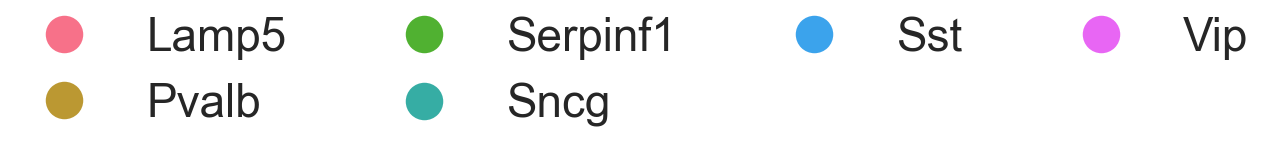

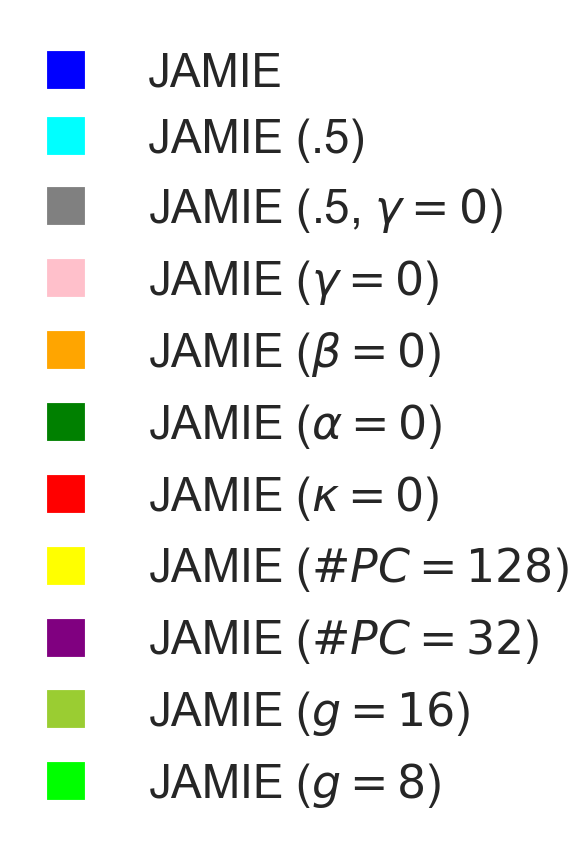

In [16]:
from IPython.display import display, Image
display( Image(filename=image_folder + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename=image_folder + dataset_name + '-AlgorithmLegend.png', width=200) )

In [17]:
# # Raw data
# fig = plt.figure(figsize=(10, 5))
# plot_regular(dataset, labels, modality_names)
# plt.tight_layout()
# plt.savefig(image_folder + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')

# # Integrated data
# for d, n in zip(integrated_data, integrated_names):
#     fig = plt.figure(figsize=(10, 5))
#     plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
#     plt.tight_layout()
#     plt.savefig(image_folder + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')

Algorithm     JAMIE  JAMIE ($\gamma=0$)  JAMIE ($\beta=0$)  \
FOSCTTM    0.002643            0.001525           0.471617   
LTA        0.950192            0.946360           0.272031   

Algorithm  JAMIE ($\alpha=0$)  JAMIE ($\kappa=0$)  
FOSCTTM              0.518793            0.004773  
LTA                  0.127805            0.947729  
Algorithm  JAMIE ($\# PC=512$)  JAMIE ($\# PC=128$)  JAMIE ($\# PC=32$)
FOSCTTM               0.002643             0.024225            0.243806
LTA                   0.950192             0.946907            0.888889
Algorithm  JAMIE ($g=32$)  JAMIE ($g=16$)  JAMIE ($g=8$)
FOSCTTM          0.002643        0.001152       0.008093
LTA              0.950192        0.943076       0.899288
Algorithm  JAMIE (.5)  JAMIE (.5, $\gamma=0$)
FOSCTTM      0.124319                0.096560
LTA          0.862343                0.914067


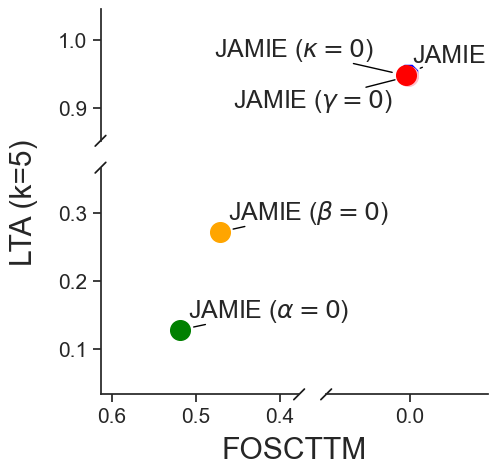

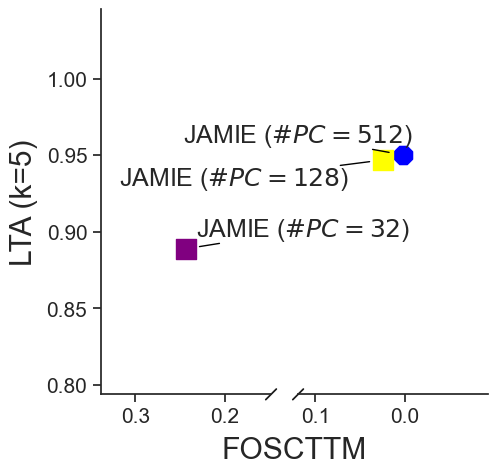

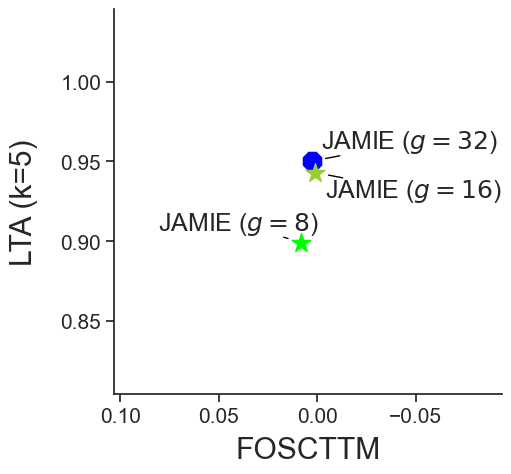

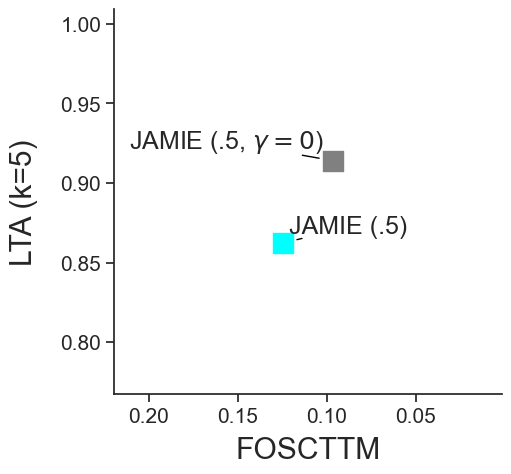

In [18]:
weight_idx = [0, 3, 4, 5, 6]
# Losses
plt.figure(figsize=(5, 5))
idx = weight_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
plt.savefig(image_folder + dataset_name + '-AccWeight.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-AccWeight.svg', format='svg', bbox_inches='tight')

pca_idx = [0, 7, 8]
# PCA
plt.figure(figsize=(5, 5))
idx = pca_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] if i != 0 else 'JAMIE ($\\# PC=512$)' for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
plt.savefig(image_folder + dataset_name + '-AccPCA.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-AccPCA.svg', format='svg', bbox_inches='tight')

dim_idx = [0, 9, 10]
# Dim
plt.figure(figsize=(5, 5))
idx = dim_idx
bax = plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] if i != 0 else 'JAMIE ($g=32$)' for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
bax.set_ylabel(f'LTA (k=5)', labelpad=55)
plt.savefig(image_folder + dataset_name + '-AccDim.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-AccDim.svg', format='svg', bbox_inches='tight')

dim_idx = [1, 2]
# .5: Gamma vs no gamma
plt.figure(figsize=(5, 5))
idx = dim_idx
bax = plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
bax.set_ylabel(f'LTA (k=5)', labelpad=55)
plt.savefig(image_folder + dataset_name + '-AccGamma.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-AccGamma.svg', format='svg', bbox_inches='tight')

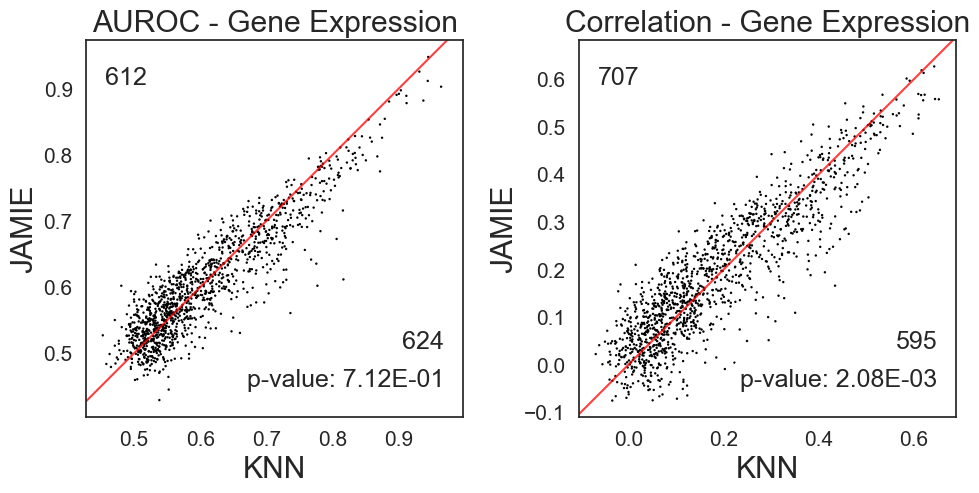

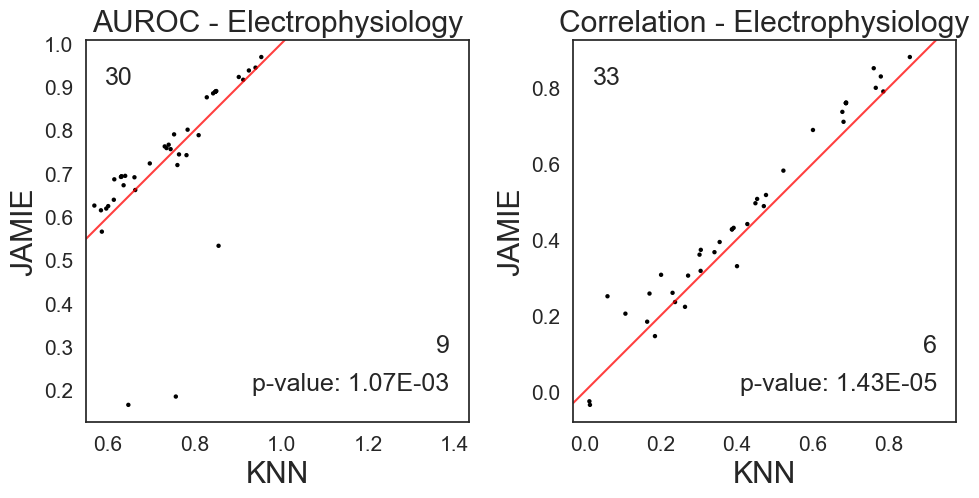

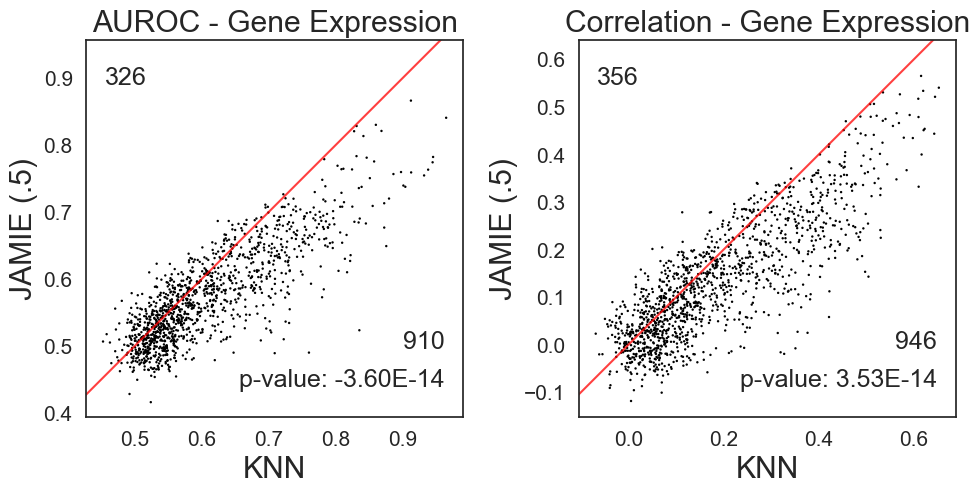

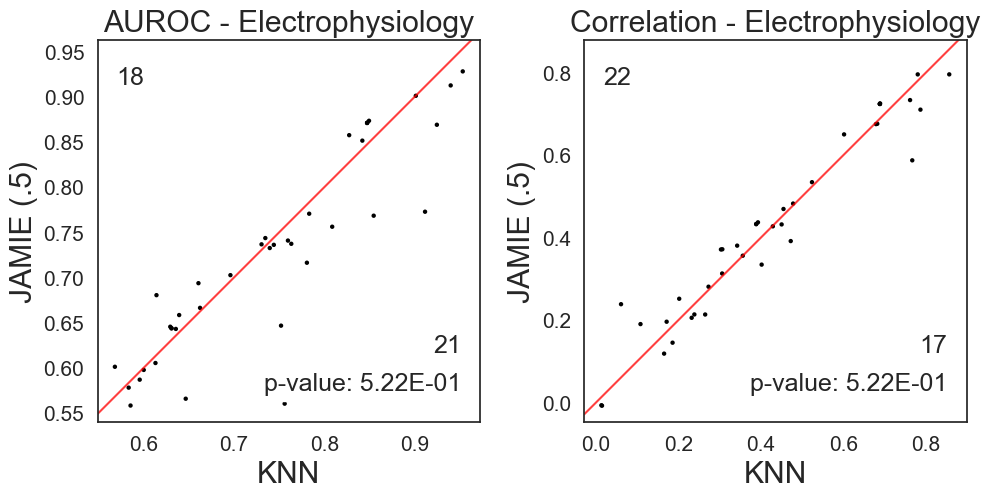

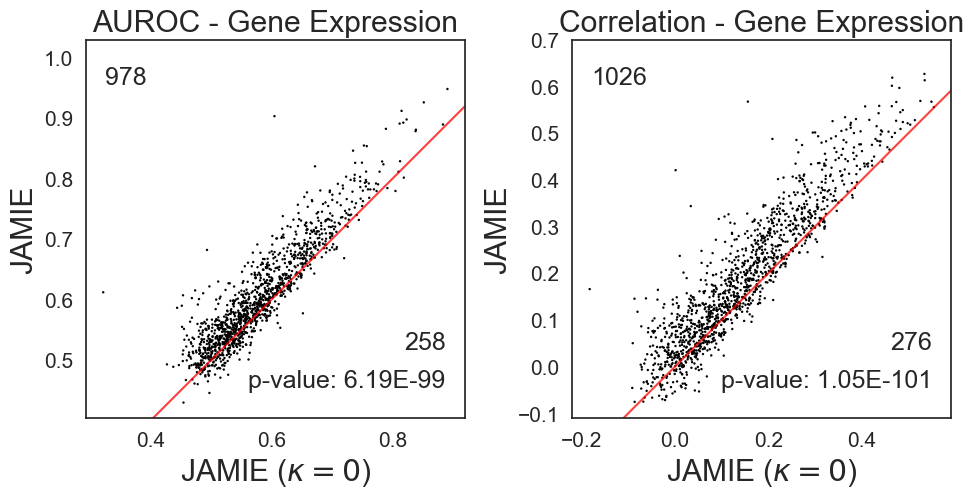

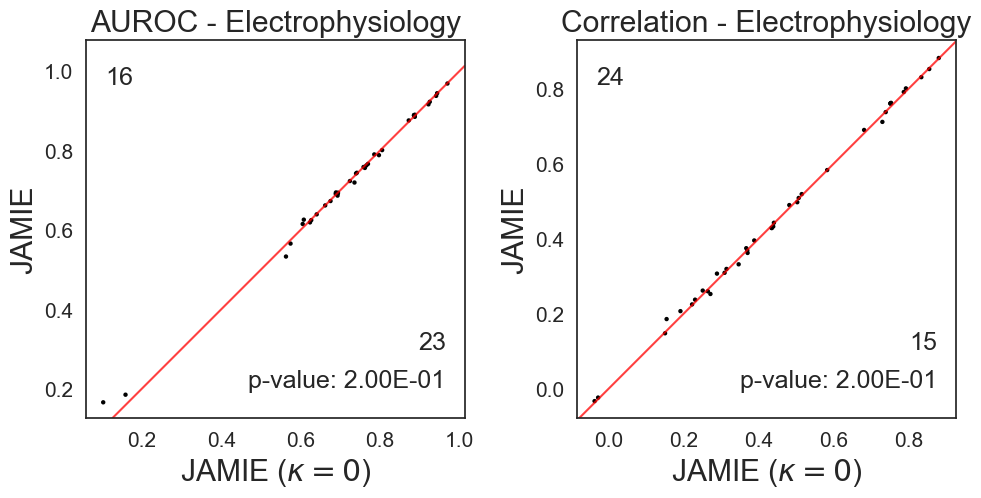

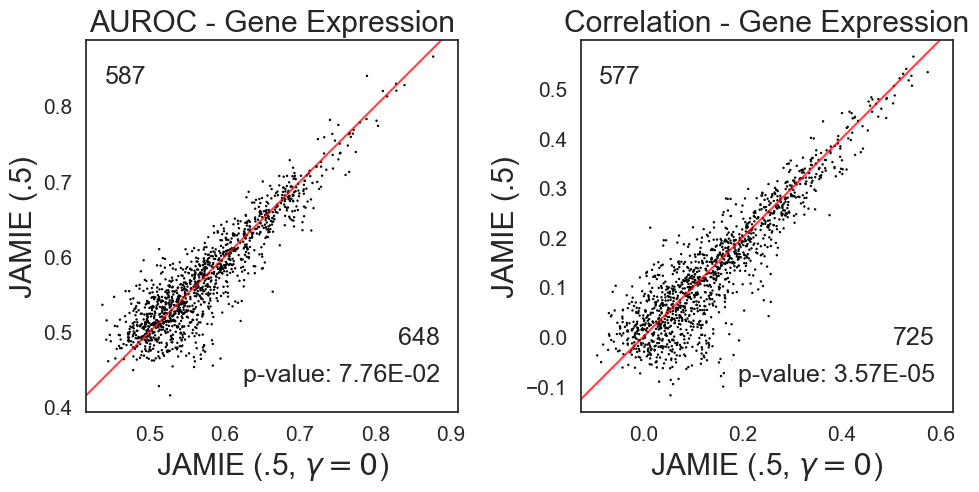

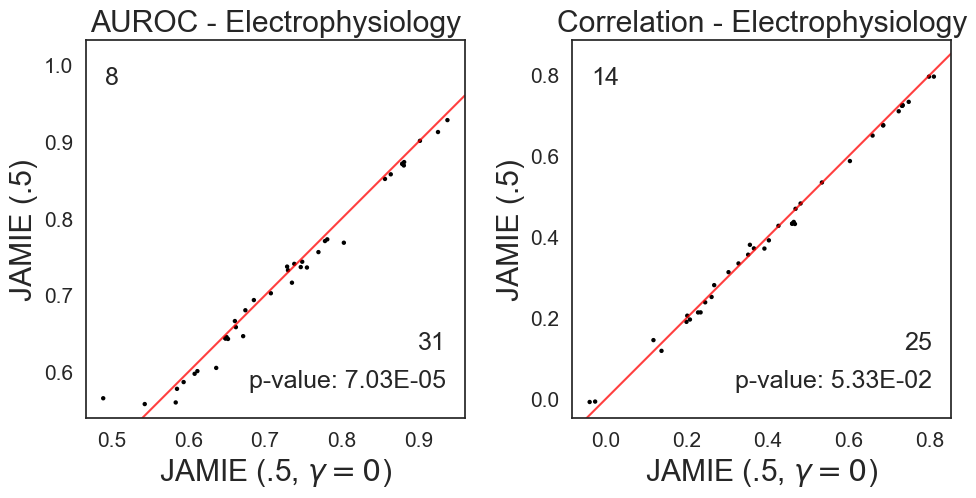

In [19]:
# JAMIE - KNN
idx = [-1, 0]
plt.figure(figsize=(10, 5))
plot_auroc_correlation([imputed_data[i] for i in idx],
                       [d[test_idx] for d in dataset],
                       modality_names, index=0,
                       names=[imputed_names[i] for i in idx])
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp1.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_auroc_correlation([imputed_data[i] for i in idx],
                       [d[test_idx] for d in dataset],
                       modality_names, index=1,
                       names=[imputed_names[i] for i in idx])
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp2.svg', format='svg', bbox_inches='tight')

# JAMIE (.5) - KNN
idx = [-1, 1]
plt.figure(figsize=(10, 5))
plot_auroc_correlation([imputed_data[i] for i in idx],
                       [d[test_idx] for d in dataset],
                       modality_names, index=0,
                       names=[imputed_names[i] for i in idx])
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1Half.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp1Half.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_auroc_correlation([imputed_data[i] for i in idx],
                       [d[test_idx] for d in dataset],
                       modality_names, index=1,
                       names=[imputed_names[i] for i in idx])
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2Half.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp2Half.svg', format='svg', bbox_inches='tight')

# JAMIE - JAMIE (kappa=0)
idx = [2, 0]
plt.figure(figsize=(10, 5))
plot_auroc_correlation([imputed_data[i] for i in idx],
                       [d[test_idx] for d in dataset],
                       modality_names, index=0,
                       names=[imputed_names[i] for i in idx])
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1Kappa.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp1Kappa.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_auroc_correlation([imputed_data[i] for i in idx],
                       [d[test_idx] for d in dataset],
                       modality_names, index=1,
                       names=[imputed_names[i] for i in idx])
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2Kappa.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp2Kappa.svg', format='svg', bbox_inches='tight')

# JAMIE (.5) - JAMIE (.5, gamma=0)
idx = [3, 1]
plt.figure(figsize=(10, 5))
plot_auroc_correlation([imputed_data[i] for i in idx],
                       [d[test_idx] for d in dataset],
                       modality_names, index=0,
                       names=[imputed_names[i] for i in idx])
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1HalfGamma.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp1HalfGamma.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
plot_auroc_correlation([imputed_data[i] for i in idx],
                       [d[test_idx] for d in dataset],
                       modality_names, index=1,
                       names=[imputed_names[i] for i in idx])
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2HalfGamma.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp2HalfGamma.svg', format='svg', bbox_inches='tight')

JAMIE (drop=.4)
	Gene Expression
		AUROC:	0.609
		Corr:	0.202
	Electrophysiology
		AUROC:	0.735
		Corr:	0.470
JAMIE
	Gene Expression
		AUROC:	0.603
		Corr:	0.187
	Electrophysiology
		AUROC:	0.728
		Corr:	0.465
JAMIE (drop=.8)
	Gene Expression
		AUROC:	0.568
		Corr:	0.128
	Electrophysiology
		AUROC:	0.709
		Corr:	0.426


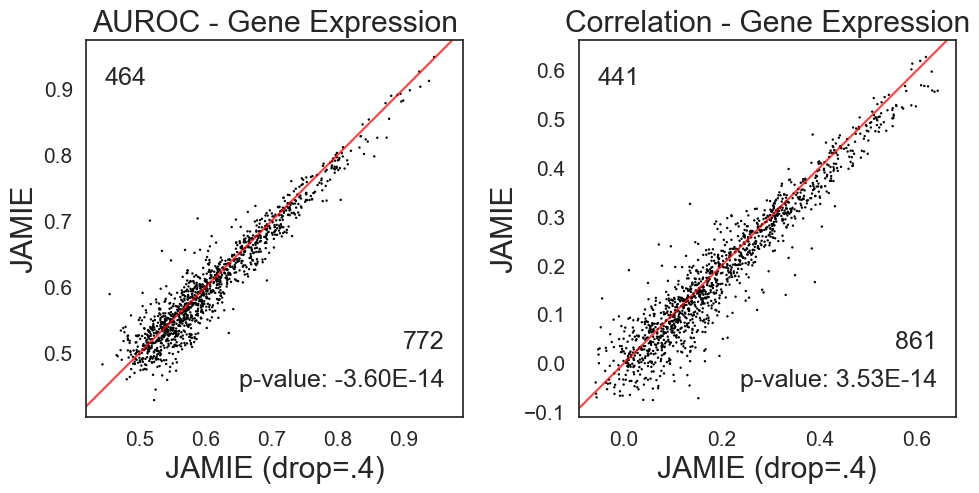

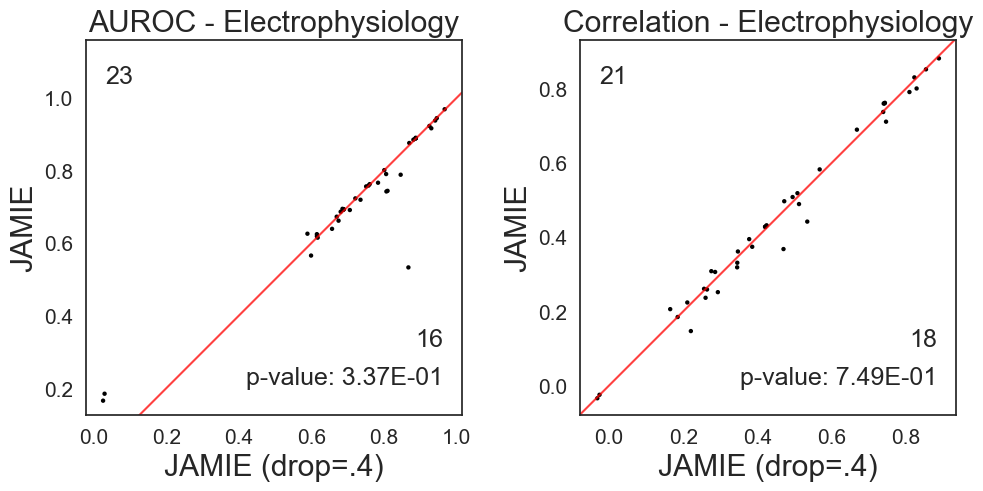

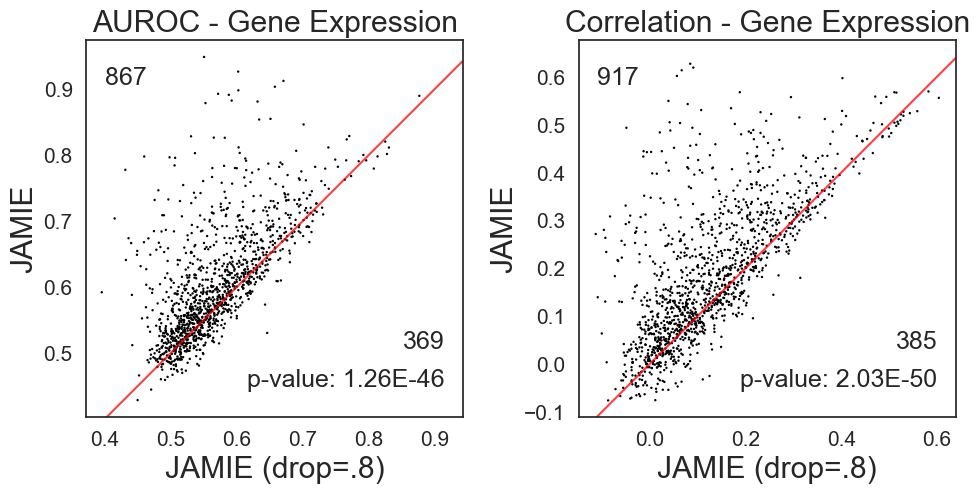

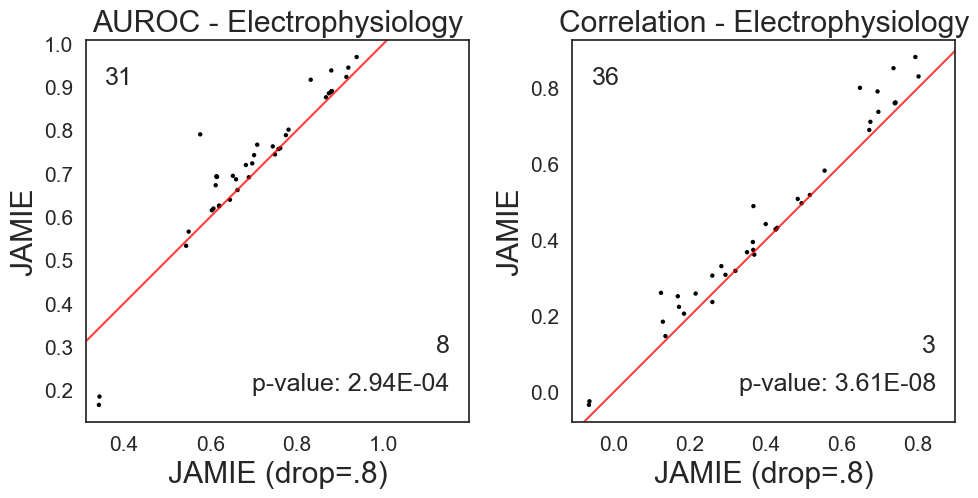

In [20]:
analyzed = []

# JAMIE (drop=.4) - JAMIE
idx = [4, 0]
plt.figure(figsize=(10, 5))
auroc_corr_0 = plot_auroc_correlation(
    [imputed_data[i] for i in idx],
    [d[test_idx] for d in dataset],
    modality_names,
    index=0,
    names=[imputed_names[i] for i in idx],
    return_statistic=True)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1DropLow.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp1DropLow.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
auroc_corr_1 = plot_auroc_correlation(
    [imputed_data[i] for i in idx],
    [d[test_idx] for d in dataset],
    modality_names,
    index=1,
    names=[imputed_names[i] for i in idx],
    return_statistic=True)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2DropLow.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp2DropLow.svg', format='svg', bbox_inches='tight')

# CLI
for i, name in enumerate([imputed_names[i] for i in idx]):
    if idx[i] in analyzed:
        continue
    print(f'{name}')
    for j, modality_name in enumerate(modality_names):
        print(f'\t{modality_name}')
        for k, statistic in enumerate(('AUROC', 'Corr')):
            print(f'\t\t{statistic}:\t{np.mean( (auroc_corr_0, auroc_corr_1)[j][k][i] ):.3f}')
for i in idx:
    if i not in analyzed:
        analyzed.append(i)

# JAMIE (drop=.8) - JAMIE
idx = [5, 0]
plt.figure(figsize=(10, 5))
auroc_corr_0 = plot_auroc_correlation(
    [imputed_data[i] for i in idx],
    [d[test_idx] for d in dataset],
    modality_names,
    index=0,
    names=[imputed_names[i] for i in idx],
    return_statistic=True)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1DropHigh.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp1DropHigh.svg', format='svg', bbox_inches='tight')

plt.figure(figsize=(10, 5))
auroc_corr_1 = plot_auroc_correlation(
    [imputed_data[i] for i in idx],
    [d[test_idx] for d in dataset],
    modality_names,
    index=1,
    names=[imputed_names[i] for i in idx],
    return_statistic=True)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2DropHigh.png', dpi=300, bbox_inches='tight')
plt.savefig(image_folder + dataset_name + '-Imp2DropHigh.svg', format='svg', bbox_inches='tight')

# CLI
for i, name in enumerate([imputed_names[i] for i in idx]):
    if idx[i] in analyzed:
        continue
    print(f'{name}')
    for j, modality_name in enumerate(modality_names):
        print(f'\t{modality_name}')
        for k, statistic in enumerate(('AUROC', 'Corr')):
            print(f'\t\t{statistic}:\t{np.mean( (auroc_corr_0, auroc_corr_1)[j][k][i] ):.3f}')
for i in idx:
    if i not in analyzed:
        analyzed.append(i)